<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


In [4]:
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

C:\Users\balra\AllAnacondafiles\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



- Source : https://www.kaggle.com/c/quora-question-pairs
- DATA: https://www.kaggle.com/c/quora-question-pairs/data
<br><br> __Useful Links__ :
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

In [ ]:
data = pd.read_csv("train.csv")
data.tail()

<h2>Data Visualisation and Cleaning</h2>

In [ ]:
data.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
questions = pd.Series(data["qid1"].tolist() + data["qid2"].tolist())

plt.figure(figsize=(20, 10))
plt.hist(questions.value_counts(), bins=160)
plt.yscale('log')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

<h3>Checking whether there are any rows with null values</h3>

In [ ]:

nan_rows = data[data.isnull().any(1)]
print (nan_rows)

In [ ]:
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

<h2>Feature Extraction</h2>
   <h3>1. Simple Features</h3>

In [ ]:
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1len'] = data['question1'].str.len() 
data['q2len'] = data['question2'].str.len()
data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
data['word_Total'] = data.apply(normalized_word_Total, axis=1)
data['common_fract'] = data['word_Common']/data['word_Total']
data['freq_sum'] = data['freq_qid1']+data['freq_qid2']
data['freq_diff'] = abs(data['freq_qid1']-data['freq_qid2'])


In [ ]:
sns.distplot(data[data['is_duplicate'] == 1.0]['common_fract'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['common_fract'][0:] , label = "0" , color = 'blue' )
plt.show()
sns.distplot(data[data['is_duplicate'] == 1.0]['freq_diff'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['freq_diff'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2>Preprocessing of Text </h2>
- Removing html tags 
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h3> 2. Advanced NLP Features </h3>

- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features...")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    print("Done")
    return df

In [ ]:
data.to_csv("nlp_features_train.csv", index=False)

In [5]:
test = pd.read_csv('nlp_features_train.csv')

In [6]:
test.tail(7)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
404283,404283,537924,537925,what do you think of the removal of the magsaf...,what will the cpu upgrade to the 2016 apple ma...,0,1,1,88,61,...,0.352939,0.0,1.0,5.0,14.5,71,59,50,54,0.209677
404284,404284,537926,537927,what does jainism say about homosexuality,what does jainism say about gays and homosexua...,1,1,1,42,51,...,0.749991,1.0,1.0,2.0,7.0,100,90,90,79,0.651163
404285,404285,433578,379845,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,0,2,2,85,79,...,0.785709,1.0,1.0,1.0,13.5,97,88,91,87,0.387500
404286,404286,18840,155606,do you believe there is life after death,is it true that there is life after death,1,12,1,41,42,...,0.555549,1.0,0.0,1.0,8.5,79,69,72,76,0.642857
404287,404287,537928,537929,what is one coin,what is this coin,0,1,1,17,17,...,0.749981,1.0,1.0,0.0,4.0,86,79,79,76,0.444444
404288,404288,537930,537931,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,0,1,1,94,127,...,0.040000,0.0,0.0,8.0,21.0,37,35,30,34,0.052632
404289,404289,537932,537933,what is like to have sex with cousin,what is it like to have sex with your cousin,0,1,1,37,45,...,0.799992,1.0,1.0,2.0,9.0,100,90,90,86,0.605263


<h2>Plotting to check usefulness of features</h2>
<h3>1.PairPlot</h3>

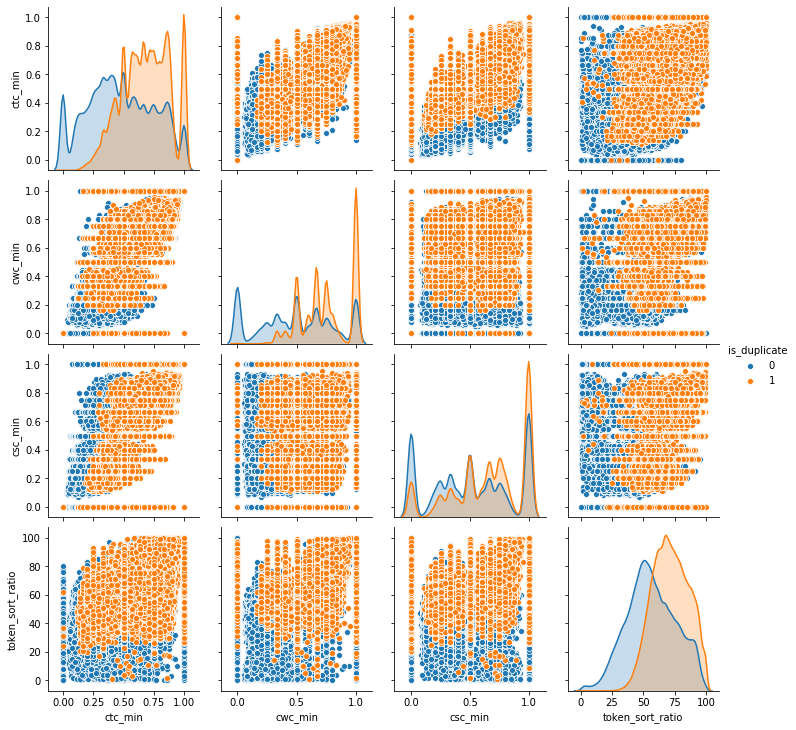

In [7]:
sns.pairplot(test[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h3>2. T-SNE</h3>

In [8]:
from sklearn.preprocessing import MinMaxScaler

sampletest = test[0:5000]
X = MinMaxScaler().fit_transform(sampletest[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = sampletest['is_duplicate'].values

In [9]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.040s...
[t-SNE] Computed neighbors for 5000 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131928
[t-SNE] Computed conditional probabilities in 0.205s
[t-SNE] Iteration 50: error = 80.5688934, gradient norm = 0.0322042 (50 iterations in 3.961s)
[t-SNE] Iteration 100: error = 69.4820480, gradient norm = 0.0033567 (50 iterations in 3.061s)
[t-SNE] Iteration 150: error = 68.1103058, gradient norm = 0.0017152 (50 iterations in 2.658s)
[t-SNE] Iteration 200: error = 67.5371323, gradient norm = 0.0012641 (50 iterations in 3.129s)
[t-SNE] Iteration 250: error = 67.2233887, gradient norm = 0.0009038

In [10]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')


<h3>3. Fetures Using TF-IDF weighted word to vectors</h3>

In [22]:
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
nlp = spacy.load('en_core_web_sm')#
trn = pd.read_csv('train.csv')
trn['question1'] = trn['question1'].apply(lambda x: str(x))
trn['question2'] = trn['question2'].apply(lambda x: str(x))#converting dtype to string

questions = list(trn['question1']) + list(trn['question2'])#list of questions
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)#find their tfidfweighted val values
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))#dictionary with each word as key and tfidf as value


In [25]:
#Converting questions to vector and putting value as mean of tfidf vlues of all words in question

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(trn['question1'])):
    doc1 = nlp(qu1) 
     
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch tfidf score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
trn['q1_feats_m'] = list(vecs1)


vecs2 = []
for qu2 in tqdm(list(trn['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
trn['q2_feats_m'] = list(vecs2)


100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [59:40<00:00, 112.90it/s]


In [34]:
#trn = trn.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
trn.head()
trn_q1 = pd.DataFrame(trn.q1_feats_m.values.tolist(), index= trn.index)
trn_q2 = pd.DataFrame(trn.q2_feats_m.values.tolist(), index= trn.index)
trn_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-14.616981,59.755488,-53.263745,19.514497,113.916473,101.657056,8.561499,66.232769,32.888127,210.812733,...,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,-3.565742,-16.844571,-130.911785,0.320254,79.350278,23.562028,79.124551,84.119839,128.684135,279.539877,...,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,156.833630,59.991896,-8.414311,29.251426,133.680218,112.457566,89.849781,21.613022,24.331766,171.114490,...,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,41.472439,56.717317,31.530616,-5.520164,33.454800,79.596179,15.508996,40.042066,21.094017,101.998116,...,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,-14.446975,-4.338255,-70.196208,-48.636382,18.356858,-50.807069,24.311196,60.043674,32.421993,57.148702,...,36.089472,47.193216,-49.969586,44.796028,39.740803,-33.763309,-98.282341,22.118795,68.802072,21.025373


In [40]:
trn_q1['id']=trn['id']
trn_q2['id']=trn['id']
res= trn_q1.merge(trn_q2,on='id',how='left')
res.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [45]:
test.head(4)
test=test.drop(['qid1','qid2','question1','question2'],axis=1)
test.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,1,66,57,14,12,10.0,23.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,4,1,51,88,8,13,4.0,20.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,1,1,73,59,14,10,4.0,24.0,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,1,1,50,65,11,9,0.0,19.0,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,3,1,76,39,13,7,2.0,20.0,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [49]:
result = test.merge(res,on='id',how='left')
result=result.drop('id',axis=1)
result.tail()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,common_fract,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
404285,0,2,2,85,79,14,13,11.0,25.0,0.440000,...,-1.453021,-60.300123,-74.572281,72.555646,17.551394,23.337234,88.163201,32.652129,139.499952,-13.953555
404286,1,12,1,41,42,8,9,5.0,16.0,0.312500,...,-10.365770,2.831673,-35.364427,29.808441,-71.090092,-30.439194,-29.243593,41.660253,76.917245,-4.642743
404287,0,1,1,17,17,4,3,1.0,7.0,0.142857,...,0.533134,13.967822,16.657529,-9.362394,-15.079316,-28.031886,18.059320,15.880986,54.864010,21.838973
404288,0,1,1,94,127,17,25,1.0,40.0,0.025000,...,8.017589,-4.186200,-20.924122,130.719102,-138.362690,-129.146722,-184.949646,181.573884,83.035827,35.530677
404289,0,1,1,37,45,8,10,8.0,18.0,0.444444,...,-16.260707,14.895357,-3.822268,26.590780,-32.035513,-14.920857,-24.042169,18.368365,-10.049310,5.548939


In [51]:
result.to_csv('final_features.csv')

<h1> Apply Machine Learning Model </h1>

<h2> 1.XgBoost </h2>

- I have used XgBoost as it gave me best results
- KPI is Log Loss

In [2]:
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, log_loss

In [4]:
total=pd.read_csv("final_features.csv").sample(n=300000)

In [5]:
y_true = total['is_duplicate']#Output Class
total.head()

,Unnamed: 0,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
211260,211260,0,2,2,70,31,13,8,6.0,20.0,...,6.460021,-13.781380,15.381432,-2.337376,6.953002,-9.214387,-29.245937,66.349882,-10.525339,53.364072
198391,198391,1,1,1,38,49,8,10,5.0,17.0,...,-44.436479,-35.448636,-17.510833,16.217828,-107.330662,-80.679958,-17.650736,43.076855,29.249020,3.109588
190137,190137,0,1,1,27,20,4,3,2.0,7.0,...,-4.592507,-0.192778,-12.885681,19.604703,-25.719650,4.538681,-19.654448,11.016629,20.997927,-4.819001
402406,402406,0,1,1,89,93,16,21,6.0,35.0,...,20.503421,38.206502,-49.980965,52.449827,-33.076787,-8.511333,-45.335311,49.530272,17.924532,41.409652
364758,364758,1,23,10,32,50,7,11,4.0,18.0,...,-54.294945,-18.923902,-34.759874,0.198122,-25.891668,7.371751,-10.502190,27.374629,28.342076,19.182609


In [6]:
total.drop(['Unnamed: 0', 'is_duplicate'], axis=1, inplace=True)
cols = list(total.columns)
for i in cols:
    total[i] = total[i].apply(pd.to_numeric)
    
y_true = list(map(int, y_true.values))


In [7]:
import time

# Splittting Data-Train -Test 

In [8]:
X_train,X_test, y_train, y_test = train_test_split(total, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (210000, 218)
Number of data points in test data : (90000, 218)


In [9]:
X_train

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,common_fract,freq_sum,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
185852,1,1,52,45,10,9,3.0,18.0,0.166667,2,...,-77.530589,-41.824360,6.685729,38.816073,-86.615264,8.647352,-28.383703,47.157403,132.329361,17.049933
402377,3,1,56,39,11,9,1.0,19.0,0.052632,4,...,3.837313,-15.590463,-71.649946,24.484139,-46.458986,-96.457933,5.213905,25.586859,21.974382,47.993673
210629,1,2,43,49,10,10,4.0,20.0,0.200000,3,...,-12.866498,27.121402,-66.519106,-6.835825,16.857993,45.250713,57.641530,100.031499,76.474625,131.089888
350980,19,8,37,74,7,14,5.0,21.0,0.238095,27,...,-58.623730,24.966005,-15.666756,37.496934,-45.417611,-6.715327,68.967899,6.769559,-2.385121,125.161739
108814,3,1,85,43,14,8,1.0,22.0,0.045455,4,...,5.670633,58.237073,-52.065109,23.451302,-14.088170,-24.402084,-5.902965,-25.404765,-24.080022,35.949350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242788,1,1,52,145,8,27,3.0,35.0,0.085714,2,...,74.928927,29.155382,-3.188350,197.875920,-84.008685,-59.461328,-50.521604,50.563181,24.028878,131.476518
192451,2,4,16,35,4,8,2.0,11.0,0.181818,6,...,-87.180758,-17.498537,1.326053,15.472027,-51.660618,-39.089173,83.037712,105.027405,70.237969,24.604750
39214,1,4,43,34,9,7,6.0,16.0,0.375000,5,...,-4.053247,-32.788256,-22.733157,4.962735,-36.842212,-11.764931,27.493169,11.435221,-30.006379,21.685087
245641,7,2,28,27,6,7,4.0,13.0,0.307692,9,...,-46.448400,4.391176,16.067030,8.830774,0.019942,51.597898,-40.810345,21.512903,16.911838,-5.087711


In [96]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    #Recall =(((C.T)/(C.sum(axis=1))).T) = 1
    Precision =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

# Hyper Parameter Tuning with Cross Validation
<h3>1. eta</h3>

In [30]:
params = {}
params['eval_metric'] = 'logloss'
params['objective'] = 'binary:logistic'


d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [16]:
min_logloss = float("Inf")
best_eta = None

for eta in [.1, .05, .02,.01, .005,.0005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,d_train,num_boost_round=450,seed=42,nfold=4,metrics=['logloss'],early_stopping_rounds=15)
    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLL {} for {} rounds\n".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_eta = eta

CV with eta=0.1
Wall time: 16min 2s
	LL 0.3371625 for 237 rounds

CV with eta=0.05
Wall time: 27min 57s
	LL 0.3351345 for 449 rounds

CV with eta=0.02
Wall time: 22min 45s
	LL 0.34414874999999995 for 449 rounds

CV with eta=0.01
Wall time: 22min 25s
	LL 0.35801725 for 449 rounds

CV with eta=0.005
Wall time: 22min 12s
	LL 0.38752875 for 449 rounds

CV with eta=0.0005
Wall time: 21min 48s
	LL 0.60684675 for 449 rounds



In [39]:
best_eta

NameError: name 'best_eta' is not defined

<h3>2. maxdepth</h3>

In [40]:
params['eta'] = 0.05

In [20]:

min_logloss = float("Inf")
best_depth = None

for depth in range(8):
    print("CV with maxdepth={}".format(depth))
    # We update our parameters
    params['max_depth'] = depth
    # Run and time CV
    %time cv_results = xgb.cv(params,d_train,num_boost_round=450,seed=42,nfold=4,metrics=['logloss'],early_stopping_rounds=15)
    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLL {} for {} rounds\n".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_depth = depth
best_depth

CV with maxdepth=0
Wall time: 24.8 s
	LL 0.65740475 for 113 rounds

CV with maxdepth=1
Wall time: 4min 30s
	LL 0.397908 for 449 rounds

CV with maxdepth=2
Wall time: 8min 37s
	LL 0.36259774999999994 for 449 rounds

CV with maxdepth=3
Wall time: 11min 55s
	LL 0.34910325 for 449 rounds

CV with maxdepth=4
Wall time: 15min 25s
	LL 0.343269 for 449 rounds

CV with maxdepth=5
Wall time: 18min 49s
	LL 0.3381095 for 449 rounds

CV with maxdepth=6
Wall time: 22min 38s
	LL 0.3351345 for 449 rounds

CV with maxdepth=7
Wall time: 27min 53s
	LL 0.333613 for 448 rounds



7

In [41]:
params['max_depth'] = 8

<h2>Train and Test Model</h2

In [70]:

watchlist = [(d_train, 'train'), (d_test, 'valid')]
model = xgb.train(params,d_train,400,
                watchlist,
                early_stopping_rounds=20,
                verbose_eval=10)
print("Best Log Loss: {:.4f} with {} rounds".format(model.best_score,model.best_iteration+1))
xgdmat = xgb.DMatrix(X_train,y_train)

[0]	train-logloss:0.66896	valid-logloss:0.66927
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.51491	valid-logloss:0.51768
[20]	train-logloss:0.44052	valid-logloss:0.44541
[30]	train-logloss:0.39987	valid-logloss:0.40645
[39]	train-logloss:0.37734	valid-logloss:0.38532
Best Log Loss: 0.3853 with 40 rounds


In [98]:
loaded_model = xgb.Booster()
loaded_model.load_model("XGB Model.model")

In [109]:
predict_y1 = loaded_model.predict(d_test)
predicted_y1 =np.array(predict_y1>0.5,dtype=int)

array([0, 1, 1, ..., 0, 1, 1])

Total number of data points : 90000
Log Loss 0.27859259049319196
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     56719
           1       0.85      0.81      0.83     33281

    accuracy                           0.87     90000
   macro avg       0.87      0.86      0.86     90000
weighted avg       0.87      0.87      0.87     90000



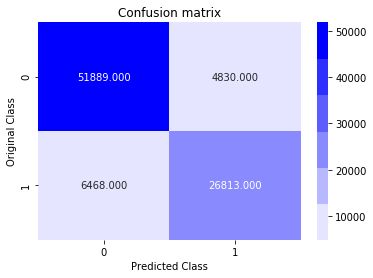

In [118]:
print("Total number of data points :", len(predicted_y1))
print("Log Loss",log_loss(y_test, predict_y1))
plot_confusion_matrix(y_test, predicted_y1)
print(classification_report(y_test, predicted_y1))

<h2>2. Random Forest</h2>

- Done to Show difference 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [24]:
X_train, y_train


In [27]:
alpha = [200,500,1000]
max_depth = [16,12,8]
log_error_array = []
for i in alpha:
    for j in max_depth:
        print('For n_estimators =',i," and max_depth =",j)
        clf= RandomForestClassifier(n_estimators= i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        predict_y = sig_clf.predict_proba(X_test)
        log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
        print("The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 200  and max_depth = 16
The log loss is: 0.35089998184195015
For n_estimators = 200  and max_depth = 12
The log loss is: 0.36183575825399794
For n_estimators = 200  and max_depth = 8
The log loss is: 0.3825840081894028
For n_estimators = 500  and max_depth = 16
The log loss is: 0.35047610784343247
For n_estimators = 500  and max_depth = 12
The log loss is: 0.361606164044948
For n_estimators = 500  and max_depth = 8
The log loss is: 0.38229467624557634
For n_estimators = 1000  and max_depth = 16
The log loss is: 0.35039899456777507
For n_estimators = 1000  and max_depth = 12
The log loss is: 0.36171611853323754
For n_estimators = 1000  and max_depth = 8
The log loss is: 0.3820804008226904


In [58]:
a = 200
depth = 16
print('For n_estimators =',a )
clf= RandomForestClassifier(n_estimators= alpha, criterion='gini',random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y2 = sig_clf.predict_proba(X_test)
log_error_array.append(log_loss(y_test, predict_y2, labels=clf.classes_, eps=1e-15))
print("The log loss is:",log_loss(y_test, predict_y2, labels=clf.classes_, eps=1e-15))

For n_estimators = 200
The log loss is: 0.3388587797329648


In [111]:
predicty2=predict_y2[:,1]
predicted_y =np.array(predicty2>0.5,dtype=int)
predicted_y

array([1, 1, 1, ..., 0, 1, 1])

Total number of data points : 90000
Log Loss 0.3388587797329648
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     56719
           1       0.80      0.75      0.77     33281

    accuracy                           0.84     90000
   macro avg       0.83      0.82      0.82     90000
weighted avg       0.83      0.84      0.84     90000



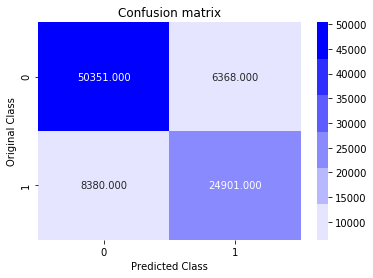

In [117]:
print("Total number of data points :", len(predicted_y))
print("Log Loss",log_loss(y_test, predicty2))
plot_confusion_matrix(y_test, predicted_y)
print(classification_report(y_test, predicted_y))